In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("../data/train_embedded_bert.csv")
df_train["sentence_embedding"] = df_train["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

df_test = pd.read_csv("../data/test_embedded_bert.csv")
df_test["sentence_embedding"] = df_test["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

In [3]:
def label_to_one_hot(label):
    one_hot = [0, 0, 0]
    one_hot[label] = 1
    return one_hot


df_train["yhot"] = df_train["label"].apply(label_to_one_hot)

In [4]:
X_train = np.zeros(shape=(len(df_train), 768))
for i in range(len(df_train)):
    X_train[i] = df_train["sentence_embedding"].values[i]

In [5]:
y_train = np.zeros(shape=(len(df_train), 3))
for i in range(len(df_train)):
    y_train[i] = df_train["yhot"].values[i]
y_train = y_train.astype(int)

first model

In [6]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(128, input_dim=768, activation='relu'))
    model.add(Dense(64, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    print(model.summary())
    return model

ACCURACY metric

In [7]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.15,
epochs=100, batch_size=64, verbose=1)

2022-01-04 18:10:45.063096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 18:10:45.106619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-04 18:10:45.106638: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-04 18:10:45.107176: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 106,883
Trainable params: 106,883
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 3ms/step - loss: 1.1086 - accuracy: 0.3567 - val_loss: 1.0930 - val_accuracy: 0.3938
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0950 - accuracy: 0.3657 - val_loss: 1.0894 - val_accuracy: 0.3889
Epoch 3/100
161/161 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


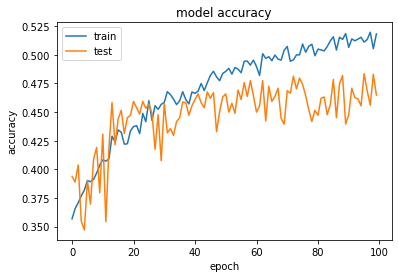

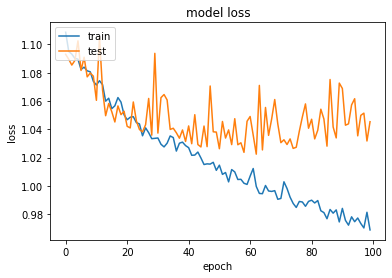

In [8]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [9]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 106,883
Trainable params: 106,883
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 4ms/step - loss: 1.1076 - auc: 0.5178 - val_loss: 1.1122 - val_auc: 0.5178
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0977 - auc: 0.5278 - val_loss: 1.0858 - val_auc: 0.5700
Epoch 3/100
161/161 [====================

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


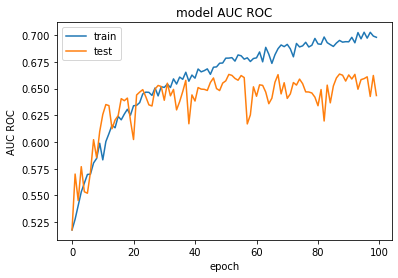

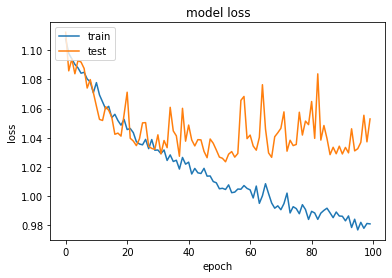

In [10]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict df_test with ANN

In [11]:
X_test = np.zeros(shape=(len(df_test), 768))
for i in range(len(df_test)):
    X_test[i] = df_test["sentence_embedding"].values[i]

In [12]:
prediction = model.predict(X_test)

In [13]:
prediction

array([[0.46820486, 0.33671314, 0.19508207],
       [0.25737277, 0.60905015, 0.13357705],
       [0.64628744, 0.20088924, 0.15282333],
       ...,
       [0.30125377, 0.3307474 , 0.3679988 ],
       [0.60230416, 0.22411978, 0.17357613],
       [0.4114223 , 0.26849464, 0.3200831 ]], dtype=float32)

In [14]:
df_test["prediction_hot"] = [row for row in prediction]

In [15]:
df_test["prediction"] = df_test["prediction_hot"].apply(lambda x : np.array(x).argmax())

In [16]:
submission = df_test[["id","prediction"]]

In [17]:
submission.to_csv("../data/submission_ann.csv")

with less layers

In [28]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(32, input_dim=768, activation='relu'))
    model.add(Dense(16, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    print(model.summary())
    return model

ACCURACY metric

In [29]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.15,
epochs=100, batch_size=64, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 32)                24608     
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 3)                 51        
                                                                 
Total params: 25,187
Trainable params: 25,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 2ms/step - loss: 1.1002 - accuracy: 0.3487 - val_loss: 1.0918 - val_accuracy: 0.3795
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0945 - accuracy: 0.3695 - val_loss: 1.0949 - val_accuracy: 0.3482
Epoch 3/100
161/161 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


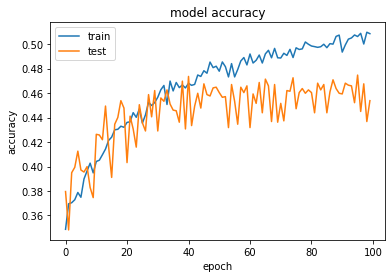

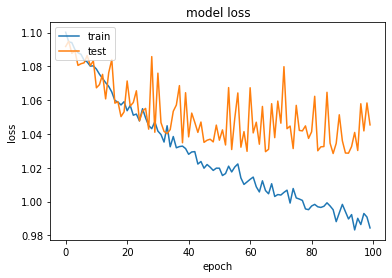

In [30]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [31]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 32)                24608     
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 3)                 51        
                                                                 
Total params: 25,187
Trainable params: 25,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 3ms/step - loss: 1.0997 - auc: 0.5304 - val_loss: 1.0901 - val_auc: 0.5574
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0947 - auc: 0.5431 - val_loss: 1.0940 - val_auc: 0.5469
Epoch 3/100
161/161 [======================

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


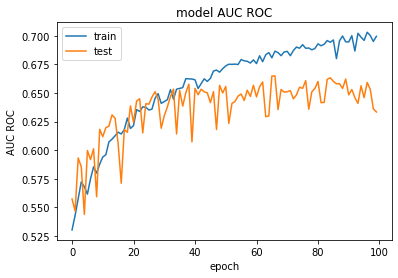

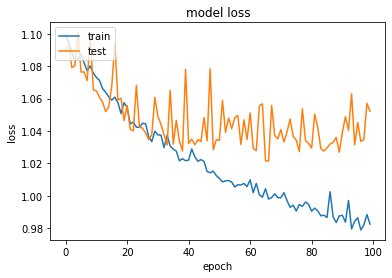

In [32]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

with even less layers

In [33]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(8, input_dim=768, activation='relu'))
    model.add(Dense(8, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    print(model.summary())
    return model

ACCURACY metric

In [34]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.15,
epochs=100, batch_size=64, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 8)                 6152      
                                                                 
 dense_33 (Dense)            (None, 8)                 72        
                                                                 
 dense_34 (Dense)            (None, 3)                 27        
                                                                 
Total params: 6,251
Trainable params: 6,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 2ms/step - loss: 1.1008 - accuracy: 0.3427 - val_loss: 1.0978 - val_accuracy: 0.3454
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0984 - accuracy: 0.3442 - val_loss: 1.0977 - val_accuracy: 0.3454
Epoch 3/100
161/161 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


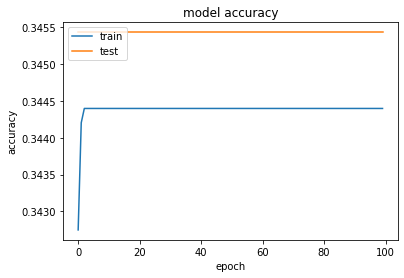

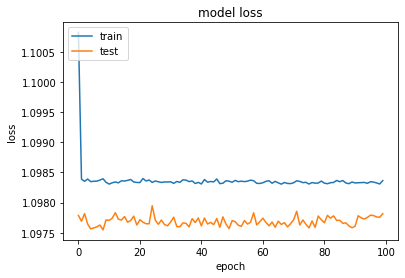

In [35]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [36]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 8)                 6152      
                                                                 
 dense_36 (Dense)            (None, 8)                 72        
                                                                 
 dense_37 (Dense)            (None, 3)                 27        
                                                                 
Total params: 6,251
Trainable params: 6,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 3ms/step - loss: 1.0995 - auc: 0.5151 - val_loss: 1.0931 - val_auc: 0.5595
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0947 - auc: 0.5357 - val_loss: 1.0875 - val_auc: 0.5648
Epoch 3/100
161/161 [========================

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


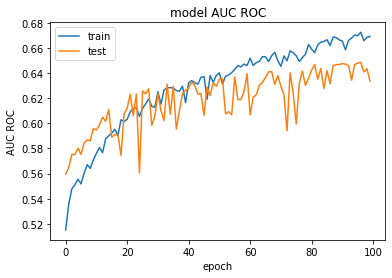

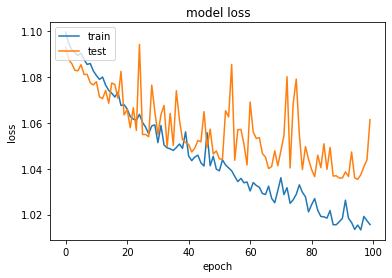

In [37]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

inbetween less and even less

In [38]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(16, input_dim=768, activation='relu'))
    model.add(Dense(16, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    print(model.summary())
    return model

ACCURACY metric

In [39]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.15,
epochs=100, batch_size=64, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                12304     
                                                                 
 dense_39 (Dense)            (None, 16)                272       
                                                                 
 dense_40 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,627
Trainable params: 12,627
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 3ms/step - loss: 1.0985 - accuracy: 0.3480 - val_loss: 1.0892 - val_accuracy: 0.3669
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0941 - accuracy: 0.3573 - val_loss: 1.0863 - val_accuracy: 0.3955
Epoch 3/100
161/161 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


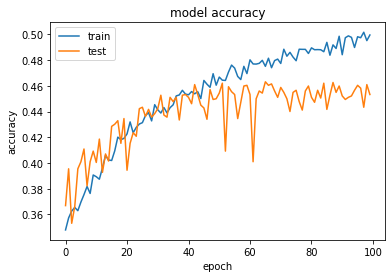

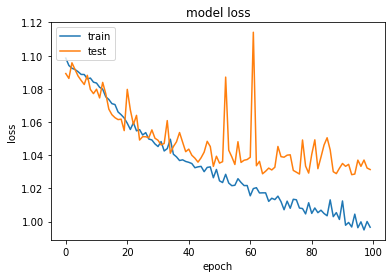

In [40]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [41]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                12304     
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 3)                 51        
                                                                 
Total params: 12,627
Trainable params: 12,627
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 4ms/step - loss: 1.0993 - auc: 0.5212 - val_loss: 1.0907 - val_auc: 0.5505
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0942 - auc: 0.5369 - val_loss: 1.0945 - val_auc: 0.5441
Epoch 3/100
161/161 [=====================

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


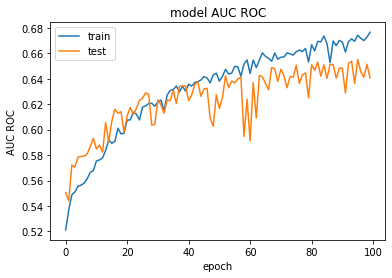

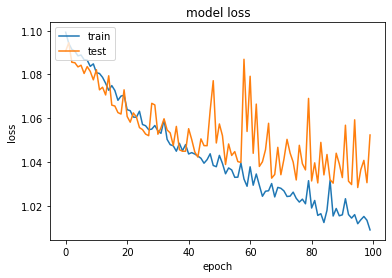

In [42]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

somewhere with not too much layers

In [50]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(12, input_dim=768, activation='relu'))
    model.add(Dense(12, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    print(model.summary())
    return model

ACCURACY metric

In [51]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.15,
epochs=100, batch_size=64, verbose=1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 12)                9228      
                                                                 
 dense_54 (Dense)            (None, 12)                156       
                                                                 
 dense_55 (Dense)            (None, 3)                 39        
                                                                 
Total params: 9,423
Trainable params: 9,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
161/161 [==============================] - 1s 2ms/step - loss: 1.0975 - accuracy: 0.3483 - val_loss: 1.0883 - val_accuracy: 0.3944
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0934 - accuracy: 0.3605 - val_loss: 1.0886 - val_accuracy: 0.3938
Epoch 3/100
161/161 [===

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


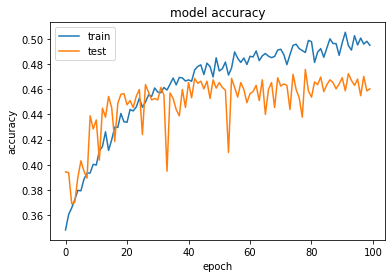

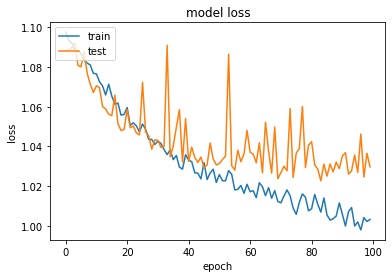

In [52]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [53]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, verbose=1)

161/161 [==============================] - 0s 2ms/step - loss: 1.0263 - auc: 0.6587 - val_loss: 1.0406 - val_auc: 0.6435
Epoch 58/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0193 - auc: 0.6660 - val_loss: 1.0306 - val_auc: 0.6535
Epoch 59/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0257 - auc: 0.6584 - val_loss: 1.0318 - val_auc: 0.6515
Epoch 60/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0171 - auc: 0.6689 - val_loss: 1.0304 - val_auc: 0.6537
Epoch 61/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0259 - auc: 0.6590 - val_loss: 1.0342 - val_auc: 0.6493
Epoch 62/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0217 - auc: 0.6627 - val_loss: 1.0400 - val_auc: 0.6429
Epoch 63/100
161/161 [==============================] - 0s 2ms/step - loss: 1.0169 - auc: 0.6679 - val_loss: 1.0329 - val_auc: 0.6543
Epoch 64/100
161/161 [==============================] - 0s 2ms/step - loss:

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


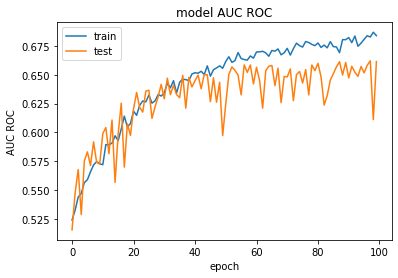

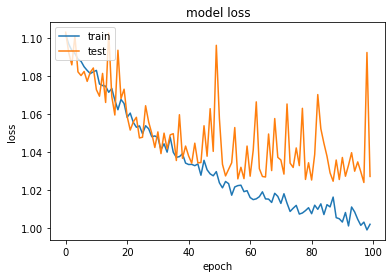

In [55]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()